# Problématique

<h3> Prédire le mot dans l'image </h3>

- Sample de 1000 observations (1000 mots) : charger (function preprocess (utiliser en sortie un .numpy() pour avoir des arrays), container toutes observations pour faire une matrice de taille (nb_observation, nb_features).
- Modèle Deep learning : RNN
- Évaluation du modèle : ?


# Import

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss


In [22]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)

<module 'ressources' from 'd:\\GitHub\\OCRpyMAN\\notebooks\\ressources.py'>

In [3]:
# BIDOUILLE SALE!! pour importer des fichiers qui ne sont pas dans le meme repertoire. les fichiers devront être mieux rangés par la suite
# import sys
# sys.path.insert(1, '../')

# import preprocessing as pp
# import ressources as rss

# Chargement du dataframe

In [2]:
# initialisation des variables globales
rss.init()

# LONG! 20mn (utile pour reprendre tout le preprocessing)
# word_df = pd.DataFrame(pp.parse_my_word_file(rss.WORDS_META_FILENAME), columns=rss.WORD_COLUMNS)
# word_df = pp.prepro_word(word_df)

In [25]:
# Chargement avec tensorflow et dataset par batch

# TO DELETE ######
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
##############

mydataset = ld_util.get_dataset()

path2.0: Tensor("x:0", shape=(), dtype=string)
path2: Tensor("filepath:0", shape=(), dtype=string) !!


In [4]:
# Chargement classic avec nk images en mémoires

img_size = (32, 128)
data = ld_util.get_dataframe_with_preprocessed_imgs(
    nb_rows = 50000,
    img_size=img_size,
    pickle_name="test",
    with_edge_detection = False
)

# data_edge_50k = ld_util.get_dataframe_with_preprocessed_imgs(
#     nb_rows = 50000,
#     img_size=img_size,
#     load_pickle_if_exists = False,
#     pickle_name="test_edge_50k",
#     with_edge_detection = True
# )

df = data['df']
preprocessed_imgs = data['preprocessed_imgs']

# df_edge = data_edge_50k['df']
# preprocessed_imgs_edge = data_edge_50k['preprocessed_imgs']

# print("Length: ", len(df))
# print("Imgs length: ", len(preprocessed_imgs))
# print("Img shape: ", preprocessed_imgs[0].shape)

Loading existing data from  ../pickle/test.pickle ...


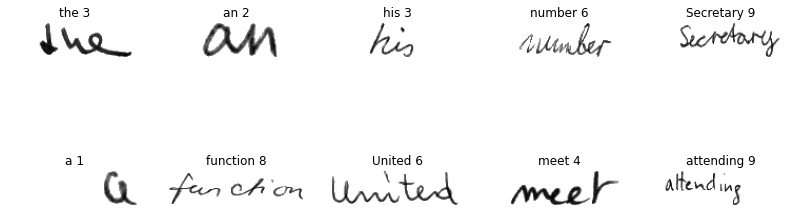

In [5]:
#CELLULE UNIQUEMENT LA POUR JOUER/VERIFIER LES DONNES


j = 1
random_indexes = np.random.randint(low=0, high=len(preprocessed_imgs), size=[10])
plt.figure(figsize=(14, 5))
for i in random_indexes:
    plt.subplot(2, 5, j)
    plt.axis('off')
    plt.imshow(preprocessed_imgs[i].reshape(img_size), cmap='gray');
    plt.title(df.iloc[i].transcription + ' ' + str(df.iloc[i].length))
    j+=1
    
# j = 1
# random_indexes = np.random.randint(low=0, high=len(preprocessed_imgs_edge), size=[10])
# plt.figure(figsize=(14, 5))
# for i in random_indexes:
#     plt.subplot(2, 5, j)
#     plt.axis('off')
#     plt.imshow(preprocessed_imgs_edge[i].reshape(img_size), cmap='gray');
#     plt.title(df_edge.iloc[i].transcription + ' ' + str(df_edge.iloc[i].length) + '(size : ' + str(len(preprocessed_imgs_edge[i])) + ')')
#     j+=1

# Model RNN

### Preprocessing

Pour le rapport, expliquer le choix des algos (RNN, CTC) par le fait qu'on ne connait pas l'alignement des lettres dans les mots, mais qu'elles suivent une certaine logique dans le temps (le nombre de mot étant fini, les lettres ont des probas plus ou moins fortes de suivre une autre lettre). Ces algos sont capables de traiter ce cas là.

In [ ]:
corpus = "".join([txt for txt in df_edge['transcription']])

char2idx = {u:i for i, u in enumerate(set(corpus))}

# pour encoder :
# text_as_int = [char2idx[c] for c in corpus]


In [ ]:
print(char2idx)


{'j': 0, 'B': 1, '-': 2, 'v': 3, 'r': 4, 'l': 5, 'h': 6, 'G': 7, 'K': 8, 't': 9, 'C': 10, 'm': 11, 'o': 12, 'P': 13, 'E': 14, 'u': 15, 'a': 16, 'e': 17, 'f': 18, 'k': 19, 'g': 20, '0': 21, 'Y': 22, 'H': 23, 'W': 24, 'y': 25, 'w': 26, 'I': 27, 'n': 28, 'x': 29, 'd': 30, 'L': 31, "'": 32, 'J': 33, 'U': 34, 'F': 35, 'i': 36, 'A': 37, 'D': 38, 'O': 39, 'N': 40, '.': 41, 'S': 42, 'q': 43, 'M': 44, 'V': 45, 'c': 46, ' ': 47, 's': 48, 'R': 49, 'p': 50, 'b': 51, 'T': 52}


In [ ]:
# ATTENTION TOUTES LES LETTRES NE SONT PAS REPRESENTEES AVEC UN ECHANTILLON DE 1000 mots!
ld_util.upper_lower(''.join(char2idx))

Lower case characters = 25 Upper case characters = 23


In [6]:
X = preprocessed_imgs #_edge

# y pre-transformée en index de caracteres pour avoir des valeurs numériques
# y = list()
# tmp = list()
# for word in df_edge['transcription']:
#     for letter in word:
#         tmp.append(char2idx[letter])
#     y.append(tmp)
#     tmp = list()

# print(y[:5])

# y sans transofrmation
y = df['transcription']

### Création Modèle

In [7]:
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Lambda
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, LeakyReLU, Dropout

model = tf.keras.Sequential()

############
# Layer 1
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='SAME', input_shape = (128, 32, 1)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# Layer 3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 4
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))

# Layer 5
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='SAME'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(MaxPooling2D(pool_size=(1,2), strides=(1,2)))
#####################


# Remove axis 2
model.add(Lambda(lambda x :tf.squeeze(x, axis=2)))
numHidden = 256
# Bidirectionnal RNN
model.add(Bidirectional(GRU(numHidden, return_sequences=True)))
model.add(Dense(100))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 32, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 128, 32, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 32, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 16, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 16, 64)       2

TypeError: Invalid shape (4096,) for image data

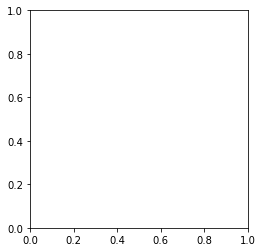

In [8]:
plt.imshow(X[0])

In [ ]:
X = np.swapaxes(X, 1, 2)

In [9]:
import string
print(string.ascii_letters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


In [9]:
# X = X.reshape(-1, 128, 32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=126)

#Definition du dataset
dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(X_train,-1), y_train))
dataset = dataset.shuffle(1000).batch(500)

########################## imports
import sys
import string
import time
############################## vars

charList = list(string.ascii_letters)+[' ']
# Définition d'un optimisateur Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

################# functions
def loss(labels, logits):
    return tf.reduce_mean(
            tf.nn.ctc_loss(
                labels = labels,
                logits = logits,
                logit_length = [logits.shape[1]]*logits.shape[0],
                label_length = None,
                logits_time_major = False,
                blank_index=-1
            )
        )

def train_op(model, inputs, targets):
    with tf.GradientTape() as tape:
        # Prédiction de notre modèle
        y_pred = model(inputs, training=True)
        # Calcule de l'erreur de notre modèle
        loss_value = tf.reduce_mean(loss(targets, y_pred))
       
    # Calculer le gradient de la fonction de perte
    grads = tape.gradient(loss_value, model.trainable_variables)
    # Descente de gradient
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # Retourner la valeur de la fonction de perte
    return loss_value.numpy()

def encode_labels(labels, charList):
    # Hash Table
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            charList,
            np.arange(len(charList)),
            value_dtype=tf.int32
        ),
        -1,  ### !!!!! pourquoi -1? ça echoue dans la ctc loss a cause de labels négatifs...  !!!!!!!!!!!!!!!!!!!! ????????????
        name='char2id'
    )
    return table.lookup(
    tf.compat.v1.string_split(labels, delimiter=''))
    
def decode_codes(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)


def greedy_decoder(logits):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )
    
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    
    # Decode the index of caracter
    text = decode_codes(codes, charList)
    
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    
    return list(map(lambda x: ''.join(x), text))

#####################################



In [ ]:
print(X_test.shape)

(200, 128, 32)


In [ ]:
b = decode_codes(encode_labels(y_train[0:5], charList), charList)
print(y_train[0:5])
tf.sparse.to_dense(b)



387       face
890        his
107       Said
125        Sir
835    despite
Name: transcription, dtype: object


<tf.Tensor: shape=(5, 7), dtype=string, numpy=
array([[b'f', b'a', b'c', b'e', b'', b'', b''],
       [b'h', b'i', b's', b'', b'', b'', b''],
       [b'S', b'a', b'i', b'd', b'', b'', b''],
       [b'S', b'i', b'r', b'', b'', b'', b''],
       [b'd', b'e', b's', b'p', b'i', b't', b'e']], dtype=object)>

In [ ]:


epochs = 5
# Entraînenement du modèle
for i in range(epochs): 
    # Pour chaque epoch
    print('---- Epoch', i, '----')
    for X_b, y_b in dataset:
        # try :
        
            y_ba = encode_labels(y_b, charList)
            print(train_op(model, X_b, y_ba))
        # except :
        #     print("Unexpected error:", sys.exc_info()[0])
        #     time.sleep(0.5)


---- Epoch 0 ----
15.074645
15.545877
16.511051
15.724434
15.947632
16.257952
15.608845
17.48657
16.257915
16.303701
15.868623
16.68809
15.399214
---- Epoch 1 ----
17.90725
16.191425
15.232109
15.279183
15.914436
16.492435
17.077843
17.123234
13.369043
14.201501
17.115183
15.258505
16.519527
---- Epoch 2 ----
13.863358
17.25161
14.616725
16.622005
16.567463
16.465319
14.361706
15.492306
15.443266
16.3494
15.660645
17.245363
14.5485935
---- Epoch 3 ----
15.170677
15.618124
14.940733
15.426996
15.114734
15.027175
15.665073
15.028481
16.571095
16.168385
16.651482
15.957669
16.210205
---- Epoch 4 ----
14.406399
15.847306
16.127457
16.132326
15.898359
16.143118
15.376791
14.170116
16.163425
15.21678
15.264494
15.225193
15.799257
---- Epoch 5 ----
13.560513
17.601894
15.587606
15.410868
15.961496
15.25642
13.74343
14.329175
15.408746
15.621776
15.2096
17.052822
15.303622
---- Epoch 6 ----
14.802531
16.104977
16.128794
16.294704
14.269992
15.39913
16.949026
16.145327
16.128922
13.570578
13.82

In [ ]:
l = greedy_decoder(model(np.expand_dims(X_train[:30], -1)))
list(zip(l, y_test[:30]))



[('', 'nominees'),
 ('', 'into'),
 ('', 'take'),
 ('', 'have'),
 ('', 'the'),
 ('', 'Mr.'),
 ('', 'support'),
 ('', 'last'),
 ('', 'talks'),
 ('', 'have'),
 ('', 'Parties'),
 ('', 'of'),
 ('', 'The'),
 ('', 'with'),
 ('', 'peers'),
 ('', 'Mr.'),
 ('', 'the'),
 ('', 'steps'),
 ('', 'Africans'),
 ('', 'of'),
 ('', 'forward'),
 ('', 'Government'),
 ('', 'overall'),
 ('', 'the'),
 ('', 'created'),
 ('', 'seeking'),
 ('', 'resolution'),
 ('', 'He'),
 ('', 'the'),
 ('', 'now')]

In [ ]:
######TESTSSSSS

# l = greedy_decoder(preds)
# list(zip(l, y_test[:30]))
from keras import backend as K

preds = model.predict(X_train)

decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

print(decoded[0])
print(decoded[1])
print(decoded[2])
print(decoded[3])

25/25 [==============================] - 5s 197ms/step
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


## From Kaggle

In [ ]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

In [ ]:

train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.2, random_state=126)

train_size = 800
valid_size= 200

train_x = np.array(train_x).reshape(-1, 128, 32, 1)
valid_x = np.array(valid_x).reshape(-1, 128, 32, 1)


alphabets = ''.join(char2idx)
max_str_len = 30 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 32 # max length of predicted labels   !!!!????? pourquoi diff de max_str_len ????


# réarrangement des targets
train_y_tmp = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train_y[i])
    train_y_tmp[i, 0:len(train_y[i])]= train_y[i]

train_y = train_y_tmp

valid_y_tmp = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid_y[i])
    valid_y_tmp[i, 0:len(valid_y[i])]= valid_y[i]

valid_y = valid_y_tmp
###############################
train_y = train_y.astype('int')
valid_y = valid_y.astype('int')



ValueError: could not convert string to float: 'Lancaster'

In [ ]:
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
print('True label : ',num_to_label(train_y[150]) , '\ntrain_y : ',train_y[150],'\ntrain_label_len : ',train_label_len[150], 
      '\ntrain_input_len : ', train_input_len[150])

True label :  is 
train_y :  [ 5 37 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] 
train_label_len :  [2.] 
train_input_len :  [30.]


### Modèle

In [ ]:
input_data = Input(shape=(128, 32, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((32, 512)), name='reshape')(inner)
inner = Dense(32, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(128, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(128, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 32, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 128, 32, 32)       320       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 32, 32)      128       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 128, 32, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 64, 16, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 64, 16, 64)        18496     
                                                           

In [ ]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)


In [ ]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=30, batch_size=128)


Epoch 1/30


C:\Users\TiBo\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


7/7 [==============================] - 21s 1s/step - loss: 94.5986 - val_loss: 84.5896
Epoch 2/30
7/7 [==============================] - 7s 1s/step - loss: 68.6965 - val_loss: 55.1174
Epoch 3/30
7/7 [==============================] - 8s 1s/step - loss: 39.5660 - val_loss: 30.6476
Epoch 4/30
7/7 [==============================] - 11s 1s/step - loss: 23.4687 - val_loss: 21.3218
Epoch 5/30
7/7 [==============================] - 9s 1s/step - loss: 20.3729 - val_loss: 19.8857
Epoch 6/30
7/7 [==============================] - 8s 1s/step - loss: 20.4571 - val_loss: 19.6912
Epoch 7/30
7/7 [==============================] - 8s 1s/step - loss: 20.0495 - val_loss: 19.3077
Epoch 8/30
7/7 [==============================] - 8s 1s/step - loss: 19.3105 - val_loss: 18.9593
Epoch 9/30
7/7 [==============================] - 8s 1s/step - loss: 18.8396 - val_loss: 18.7843
Epoch 10/30
7/7 [==============================] - 10s 1s/step - loss: 18.6092 - val_loss: 18.6348
Epoch 11/30
7/7 [====================

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))


for i in range(15):
    print('True : ', valid_y[i], '!! Pred : ', prediction[i] )

7/7 [==============================] - 4s 108ms/step
True :  [41 47  0 44  8 45 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [47  5 36 51 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [38 33 51 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [44  8 38 18 36 47 38 51 36 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [41 47  0 44  8 45 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [35 44  8 37 51 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [29 51 51 45 51 37 37 51 37 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [44 11 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1] !! Pred :  
True :  [ 1  5 38 33 -1 -1 -1 -1 -1 -1 -1 -

In [ ]:
print(max([item for sublist in preds[3] for item in sublist]))
print(max([item for item in preds[3][0]]))
# print(decoded[:5])
print(preds[3][10])
for i in range(len(preds[3])):
    print(np.argmax(preds[3][i]), end=' ')
print('\n', valid_y[3])

print(num_to_label([np.argmax(preds[3][0])]))


0.7604688
0.16396892
[4.9847453e-03 2.9768948e-03 8.1923458e-04 8.9015142e-04 7.6956960e-04
 2.0462085e-02 1.2863055e-03 1.6341049e-02 6.0865306e-03 1.1699783e-03
 5.6109915e-04 4.7165891e-03 2.7098267e-03 5.7641394e-04 7.9892110e-03
 7.8785542e-04 9.1743318e-04 1.0907425e-03 1.4652216e-03 4.1377041e-03
 4.7452201e-04 5.6902366e-03 9.0594823e-04 1.0149240e-03 2.8216569e-03
 4.5166168e-04 1.2793371e-03 9.0223858e-03 1.0829429e-03 1.6396625e-03
 6.3770817e-04 5.7237246e-04 2.9050608e-03 9.3423249e-03 8.1382145e-04
 8.9002581e-04 8.3906660e-03 1.4308949e-02 1.9362848e-02 1.1634919e-03
 1.2392041e-03 2.5124033e-03 1.1767129e-03 7.6047838e-04 2.6156796e-02
 1.6275078e-02 1.8271438e-03 1.7413078e-02 1.0891625e-03 3.2412636e-04
 2.1784434e-03 3.8823113e-02 2.1765663e-03 7.2453851e-01]
53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 53 
 [44  8 38 18 36 47 38 51 36 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1]


IndexError: string index out of range